In [1]:
import sys
import os

sys.path.append(os.path.join("..", ".."))

from footprint_model.constants.units import u
from footprint_model.constants.explainable_quantities import ExplainableQuantity
from footprint_model.utils.graph_representation import (
    build_graph, SERVICES_VIEW_CLASSES_TO_IGNORE, USAGE_PATTERN_VIEW_CLASSES_TO_IGNORE,
    SERVICES_AND_INFRA_VIEW_CLASSES_TO_IGNORE, save_graph_as_both_html_and_png)
from use_cases.multiservice_app_carbon_case.iastrologique_usage import iastrologique_yearly_modeling, USE_CASE_PATH, PLOTS_PATH
from use_cases.multiservice_app_carbon_case.utils_iastrologique import plot_from_system

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import logging

2023-09-08 10:06:10,050 - WARNING - Redefining 'octet' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,050 - WARNING - Redefining 'oct' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,051 - WARNING - Redefining 'user' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,051 - WARNING - Redefining 'user' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,052 - WARNING - Redefining 'user_journey' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,053 - WARNING - Redefining 'user_journey' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,054 - WARNING - Redefining 'core' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-09-08 10:06:10,055 - WARNING - Redefining 'core' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)


In [2]:
logging.getLogger().setLevel(logging.CRITICAL)

emissions_dict = {}
iastrologique_systems = {}
yearly_usage_df = pd.read_csv(os.path.join(USE_CASE_PATH, "yearly_nb_of_users.csv"))
for i in range(len(yearly_usage_df)):
    year = yearly_usage_df["year"].iloc[i]
    nb_paid_users_that_year = yearly_usage_df["nb_paid_users"].iloc[i]
    nb_free_users_that_year = yearly_usage_df["nb_free_users"].iloc[i]

    if i > 0:
        iastrologique_system = iastrologique_yearly_modeling(nb_paid_users_that_year, nb_free_users_that_year, iastrologique_systems[year - 1])
    else:
        iastrologique_system = iastrologique_yearly_modeling(nb_paid_users_that_year, nb_free_users_that_year)

    iastrologique_systems[year] = iastrologique_system

    emissions_dict[year] = [iastrologique_system.energy_footprints(), iastrologique_system.fabrication_footprints()]


total_emissions = []

def calculate_total_emissions(input_dicts, timespan):
    total_emissions_in_tons = 0
    for input_dict in input_dicts:
        total_emissions_in_tons += (sum(input_dict.values()) * timespan).to(u.ton).magnitude
        
    return total_emissions_in_tons

for year in range(2024, 2031):
    total_emissions.append(calculate_total_emissions(emissions_dict[year], ExplainableQuantity(1 * u.year, "one year")))

In [3]:
%%capture

iastrologique_system_2024 = iastrologique_systems[2024]
G = build_graph(iastrologique_system_2024, classes_to_ignore=SERVICES_VIEW_CLASSES_TO_IGNORE)
save_graph_as_both_html_and_png(G, os.path.join(PLOTS_PATH, "services_view.html"), 1100, 900)

# Modeling overview

## Perimeter
The perimeter of the modeling is the widest possible, including servers, storage, the network and devices at their fabrication and usage phases. Are excluded:
- the fabrication of the network, which is supposed to be negligeable because heavily shared,
- the hardware end of life and transportation, which are supposed to emit very little CO2 compared to the other phases.

The focus is exclusively on CO2 even though it is not the only source of environmental impact for digital services, because it is the indicator that is the most mature and covers every life cycle phase. Future upgrades of Publicis Sapient’s model will take other environmental impacts (like rare earth metals or water) into account.

## Functional point of view
The following image represents iastrologique’s modeling from a functional point of view. In green are user journeys, made of user journey steps in orange. The services used by each user journey step are in blue.

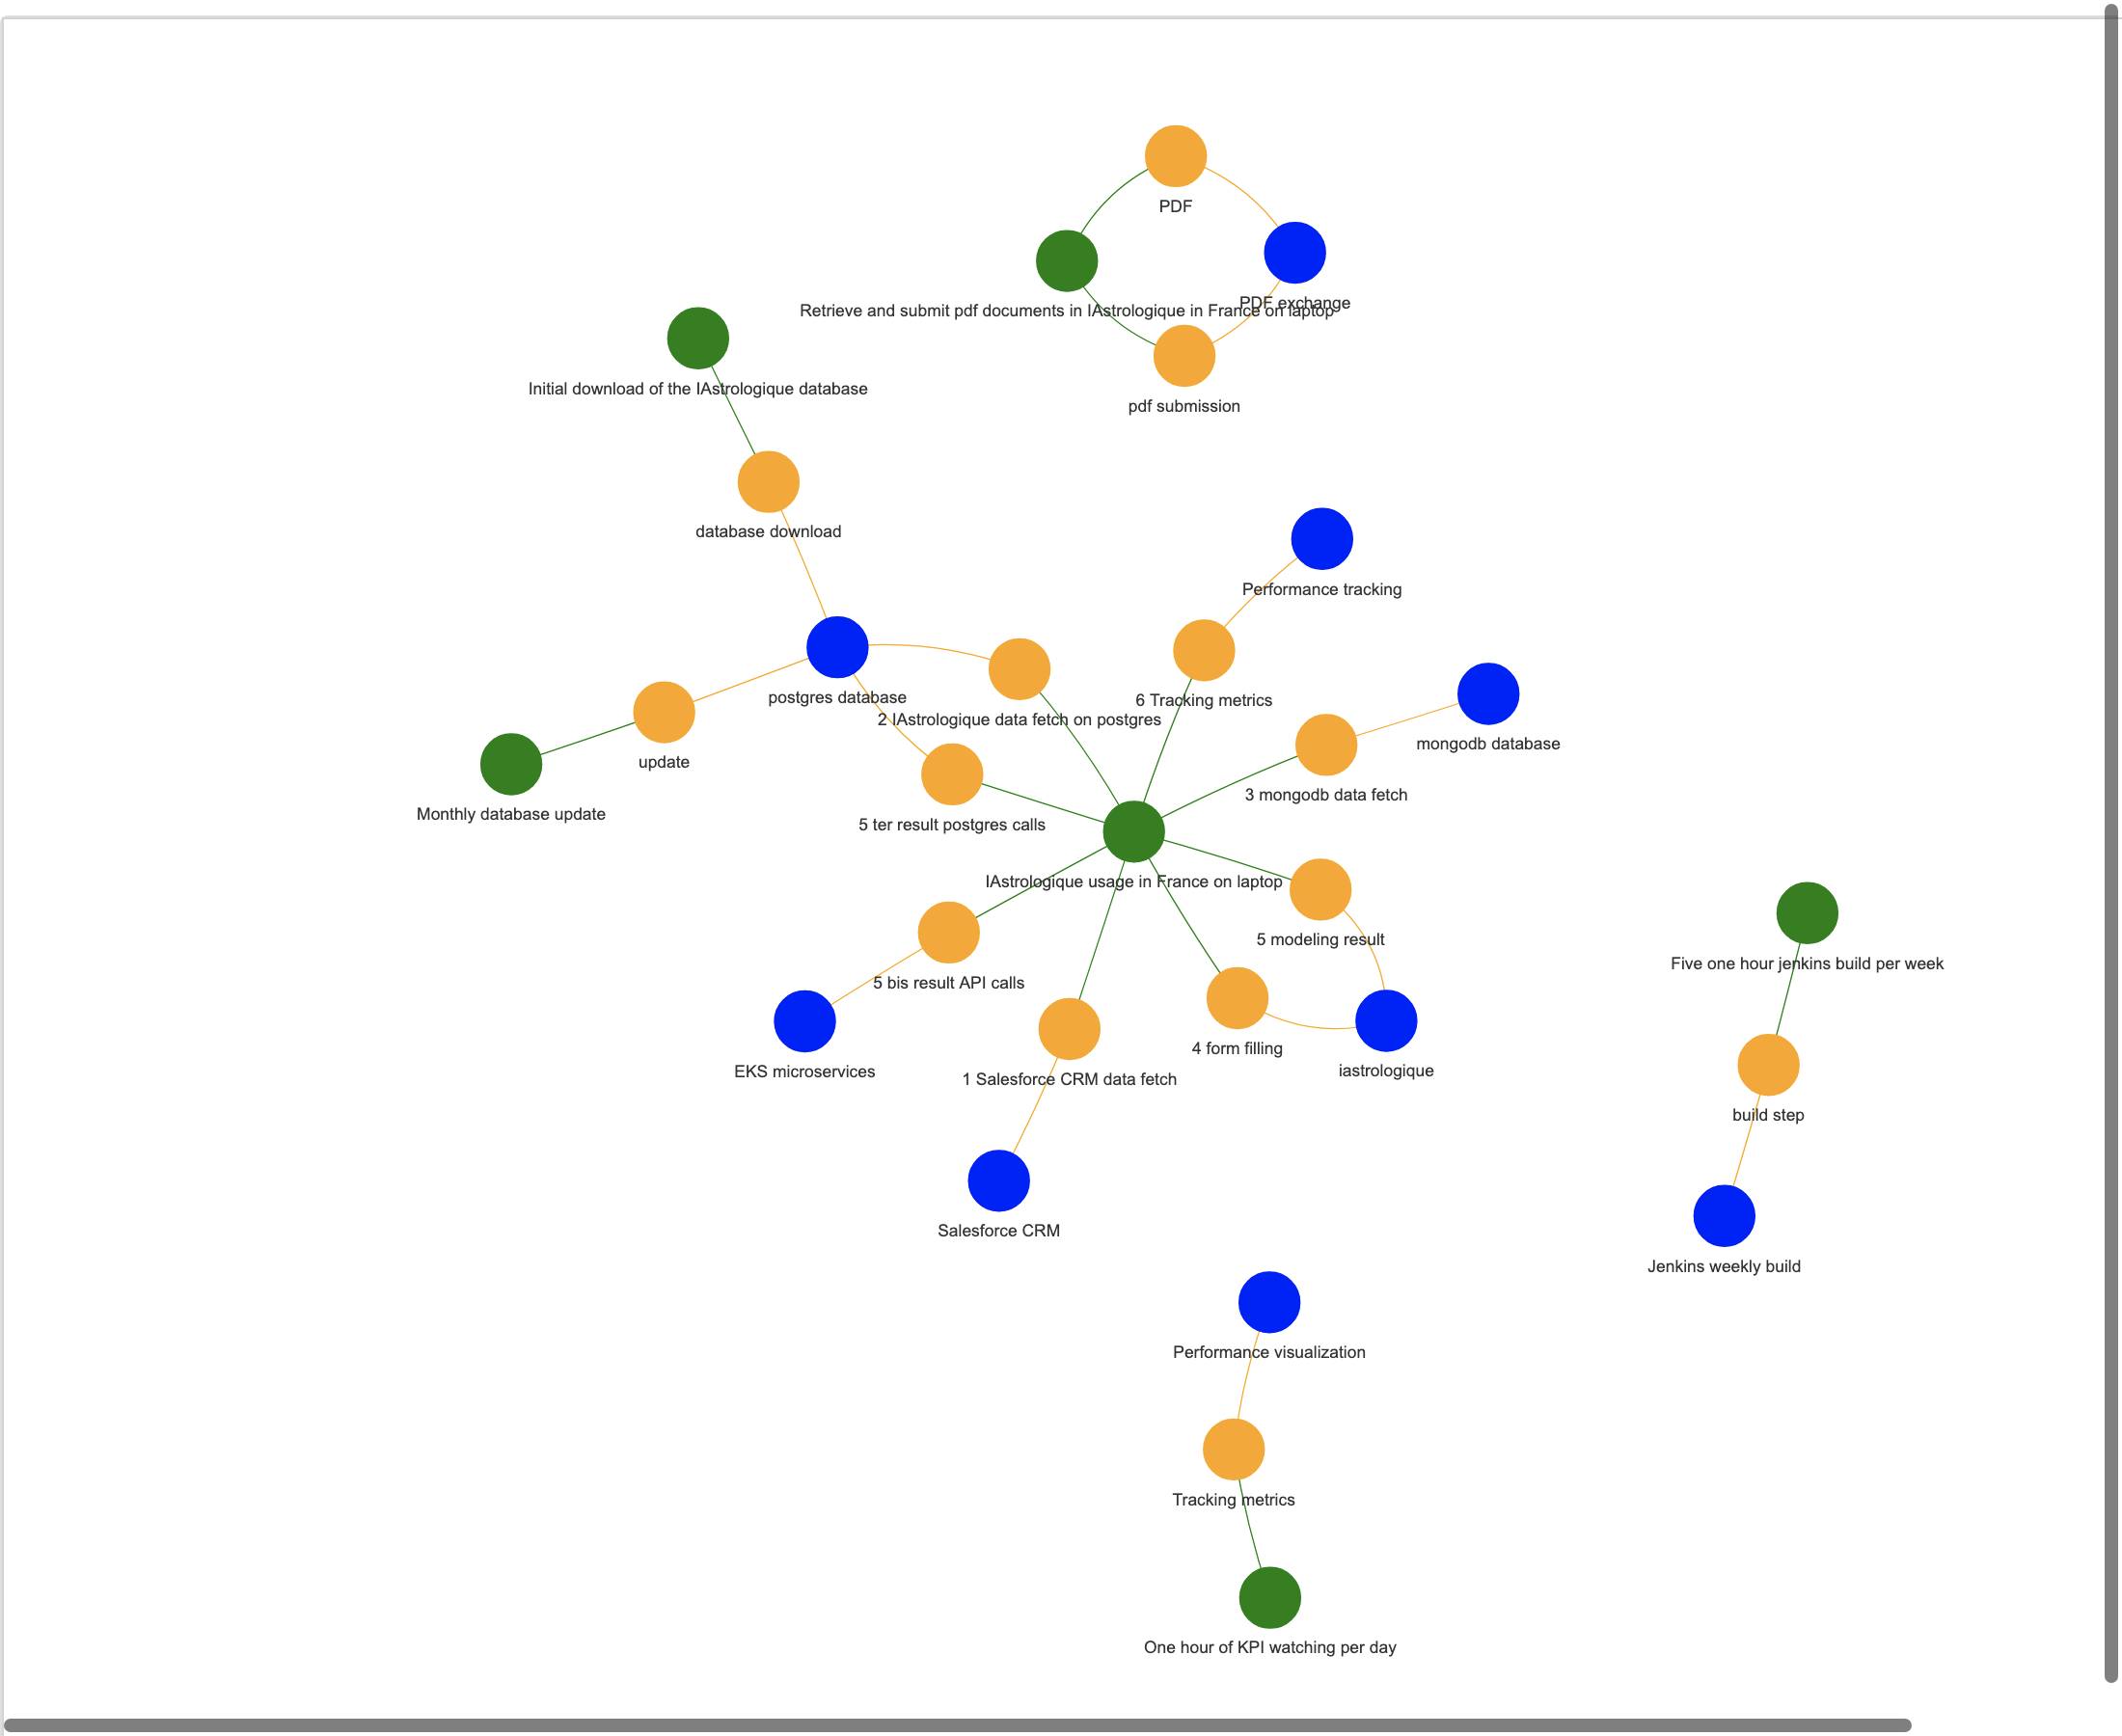

In [4]:
from IPython.display import Image, display
display(Image(os.path.join(PLOTS_PATH, "services_view.png"), width=1100, height=900))

### User journey descriptions

Here are high-level descriptions of the user journeys modeled:

In [5]:
from IPython.display import Markdown as md

string_to_display = ""
for usage_pattern in iastrologique_systems[2024].usage_patterns:
    uj = usage_pattern.user_journey
    string_to_display += f"\n{uj.name}:\n  - {round(uj.data_download.value, 1)} downloaded,\n  - {round(uj.data_upload.value)} uploaded,\n\
  - {round(usage_pattern.user_journey_freq.value, 1)}\n"

md(string_to_display)


IAstrologique usage in France on laptop:
  - 18.5 megaoctet / user_journey downloaded,
  - 5.0 megaoctet / user_journey uploaded,
  - 700000.0 user_journey / year

Retrieve and submit pdf documents in IAstrologique in France on laptop:
  - 0.2 megaoctet / user_journey downloaded,
  - 0.0 megaoctet / user_journey uploaded,
  - 220000.0 user_journey / year

Monthly database update:
  - 260.0 megaoctet / user_journey downloaded,
  - 0.0 megaoctet / user_journey uploaded,
  - 12.0 user_journey / year

Five one hour jenkins build per week:
  - 0.1 megaoctet / user_journey downloaded,
  - 0.0 megaoctet / user_journey uploaded,
  - 260.0 user_journey / year

One hour of KPI watching per day:
  - 0.2 megaoctet / user_journey downloaded,
  - 0.0 megaoctet / user_journey uploaded,
  - 365.0 user_journey / year

Initial download of the IAstrologique database:
  - 78000.0 megaoctet / user_journey downloaded,
  - 0.0 megaoctet / user_journey uploaded,
  - 1.0 user_journey / year


In [6]:
%%capture

G = build_graph(iastrologique_system_2024, classes_to_ignore=SERVICES_AND_INFRA_VIEW_CLASSES_TO_IGNORE)
save_graph_as_both_html_and_png(G, os.path.join(PLOTS_PATH, "services_and_infra_view.html"), 1100, 900)

## Infrastructure point of view

The following image represents the relationship between the physical infrastructure (servers in red, storage in burgundy) and the services. Most services have their own infrastructure but we can see notably that the MongoDB storage is shared by several services.

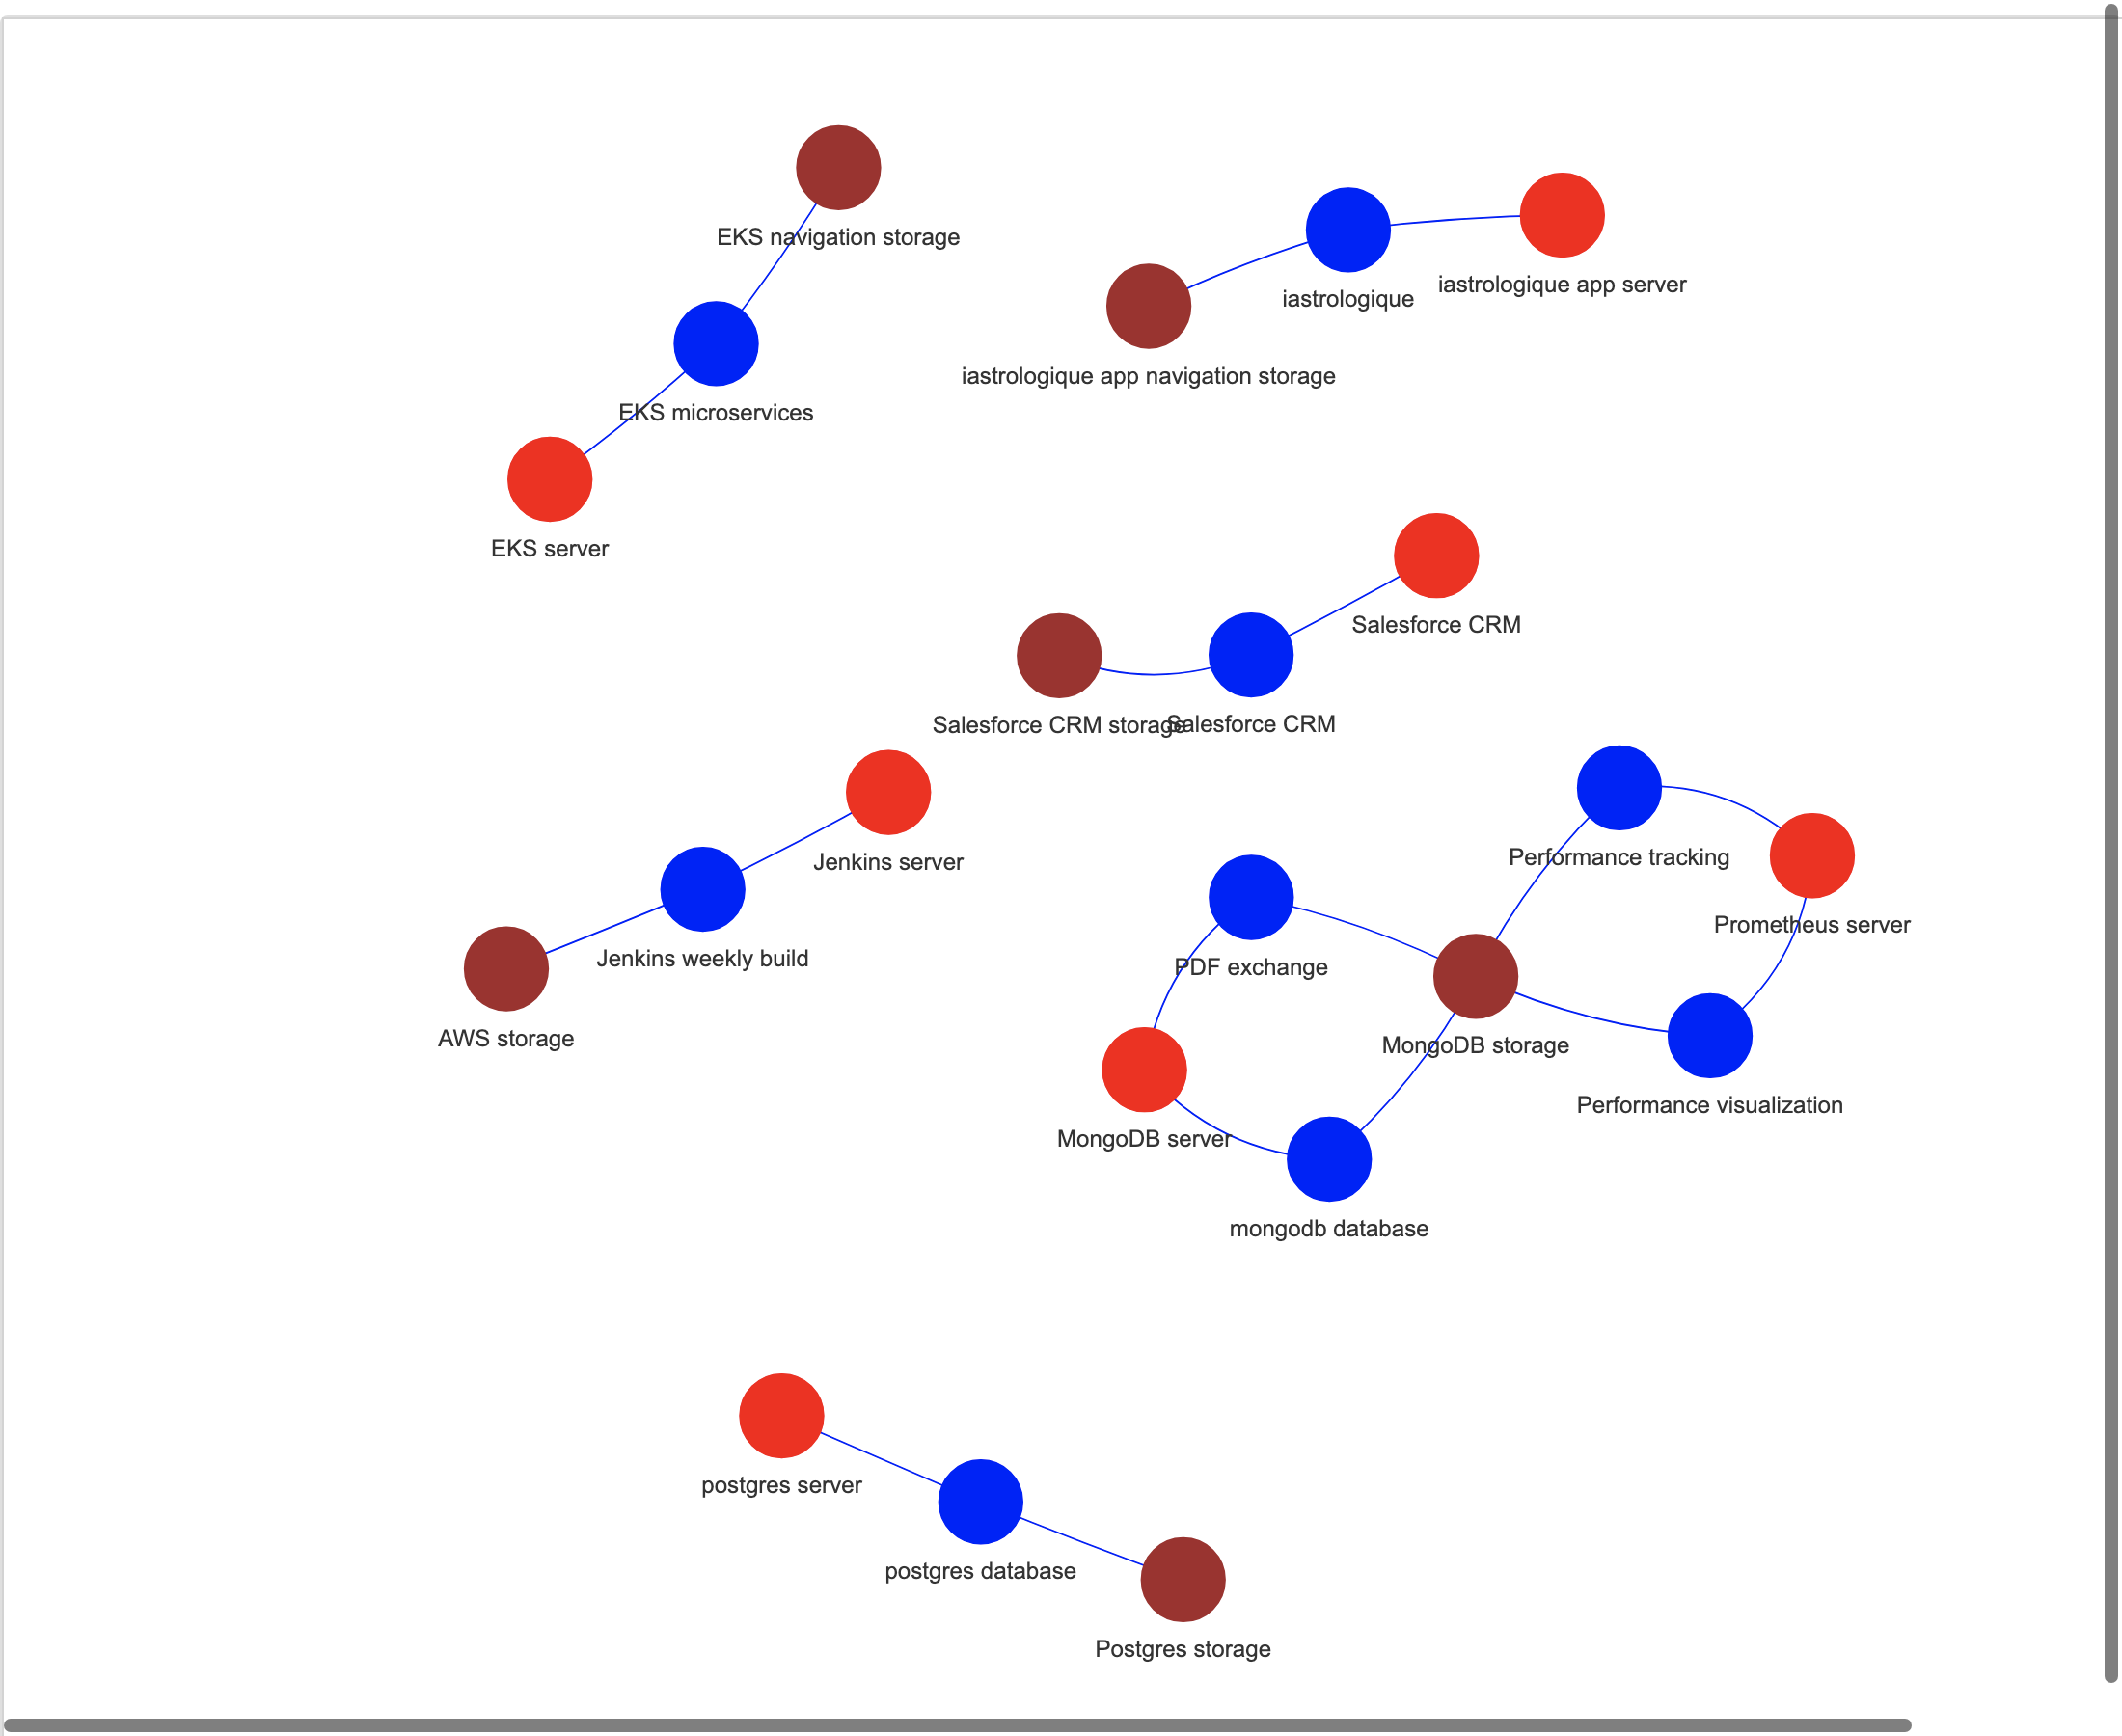

In [7]:
display(Image(os.path.join(PLOTS_PATH, "services_and_infra_view.png"), width=1100, height=900))

## Main hypotheses

- For each user journey, the usage pattern is supposed to be a stable usage on chosen hours for a typical day. For example, the IAstrologique usage is supposed to be the same from 10am till 23pm with an homogeneous repartition of the number of visits, and no visits outside of that time range.
- All uploaded data is stored forever.
- Fabrication emissions are attributed based on the ratio of the time spent by the hardware on the service over its overall lifespan.
- No hardware improvement factors have been taken into account for future years to get a conservative estimate.

# High level analysis

Let’s have a look at the amount of CO2 emitted by the system from 2024 to 2030

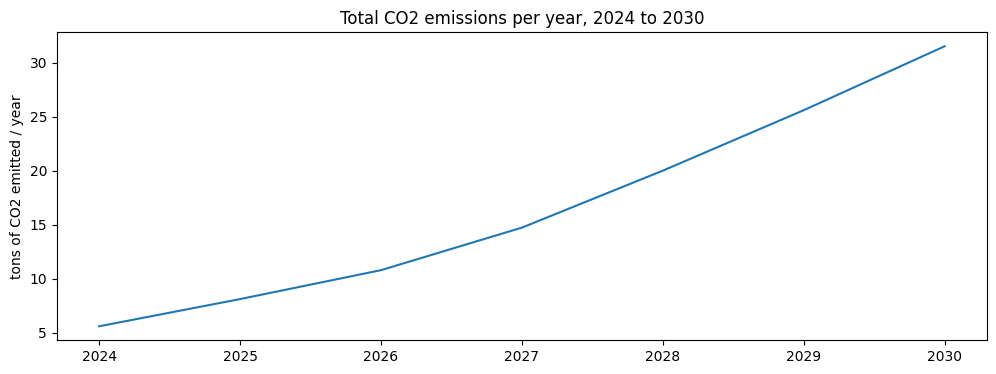

In [8]:
years = [i for i in range(2024, 2031)]

matplotlib.rcParams['figure.figsize'] = [12, 4]

plt.plot(years, [emissions for emissions in total_emissions])
plt.ylabel("tons of CO2 emitted / year")
plt.title("Total CO2 emissions per year, 2024 to 2030")
plt.show()

In [9]:
md(f"The order of magnitude of the total emissions of the system from 2024 to 2030 is about {int(sum(total_emissions)/100)*100} tons CO2eq.")

The order of magnitude of the total emissions of the system from 2024 to 2030 is about 100 tons CO2eq.

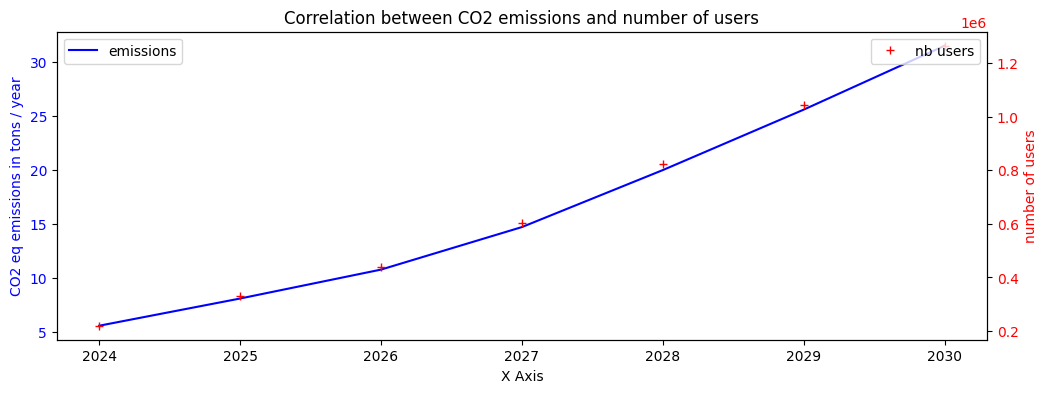

In [10]:
fig, ax1 = plt.subplots()

ax1.plot(years, [emissions for emissions in total_emissions], 'b-', label='emissions')
ax1.set_xlabel('X Axis')
ax1.set_ylabel('CO2 eq emissions in tons / year', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.plot(years, yearly_usage_df["nb_paid_users"] + yearly_usage_df["nb_free_users"], 'r+', label='nb users')
ax2.set_ylabel('number of users', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')

plt.title('Correlation between CO2 emissions and number of users')
plt.show()

Emissions are almost proportional to the number of users.

# Emissions distribution
## Servers

Let’s look at the emissions distribution in 2024:

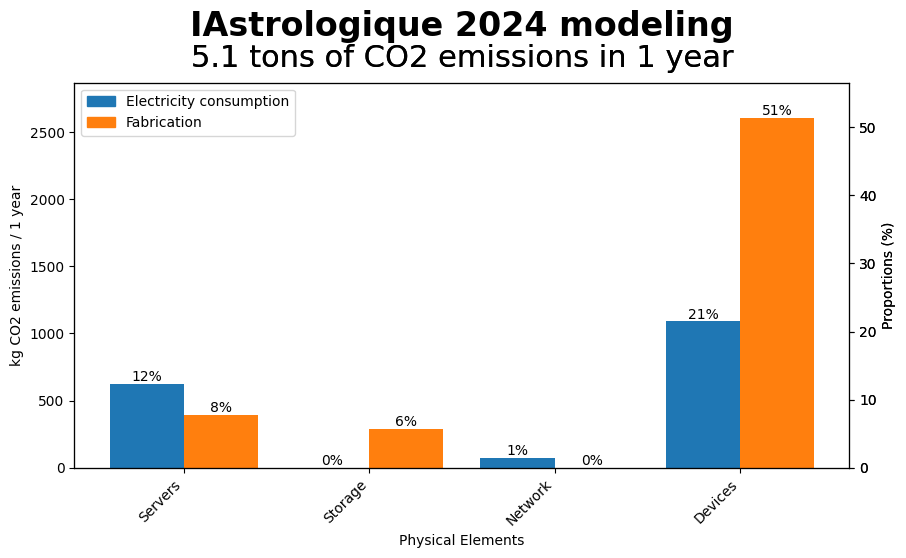

In [11]:
year = 2024
plot_from_system(
            emissions_dict[year], emissions_dict[year], "IAstrologique 2024 modeling", os.path.join(PLOTS_PATH, f"iastrologique_{year}.png"), (10, 5))

And in 2030:

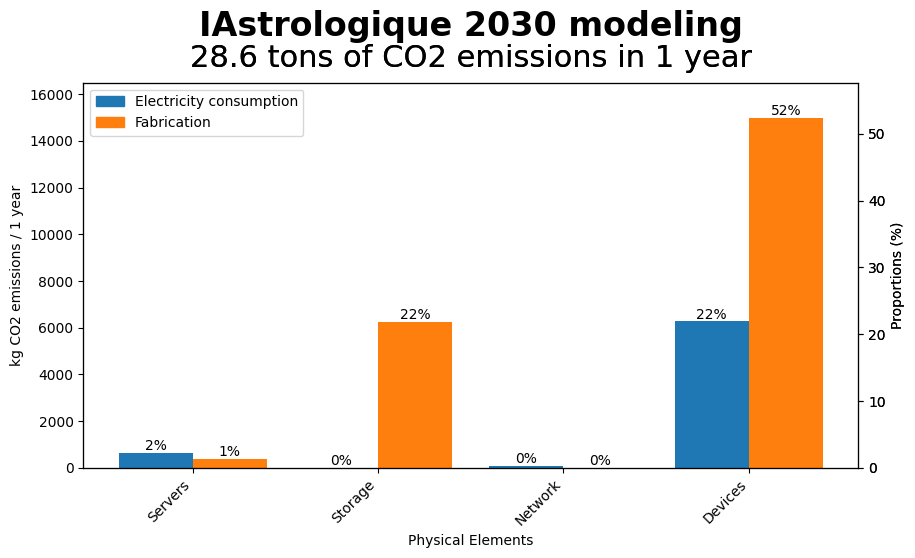

In [12]:
year = 2030
plot_from_system(
            emissions_dict[year], emissions_dict[year], "IAstrologique 2030 modeling", os.path.join(PLOTS_PATH, f"iastrologique_{year}.png"), (10, 5))

Device fabrication is the largest CO2 emissions driver, however it is important to keep in mind that this modeling attributes hardware fabrication based on the time spent on the service. Given that the IAstrologique service won’t be a mainstream social or leisure app it is quite unlikely that it would push its users to buy a new device, so conventional performance best practices should be enough in terms of ecodesign. What’s more interesting is that the devices power is second in terms of emissions. That calls for paying attention to the computing load on the device’s side: if it gets heavier than the typical web app it might become interesting to monitor it more closely with tools like [Greenframe](https://greenframe.io/).

We see that the share of devices increases with usage, as does the storage requirements, but not the server shares. That suggests that servers are underused at low usage rates. Let’s look at the iastrologique server for example:

In [13]:
iastrologique_server_2024 = iastrologique_systems[2024].get_server_by_name("iastrologique app server")
iastrologique_server_2030 = iastrologique_systems[2030].get_server_by_name("iastrologique app server")

md(f"Average number of instances of iastrologique app server in 2024: {round(iastrologique_server_2024.nb_of_instances.magnitude, 2)}  \n\
Average number of instances of iastrologique app server in 2030: {round(iastrologique_server_2030.nb_of_instances.magnitude, 2)}")

Average number of instances of iastrologique app server in 2024: 0.54  
Average number of instances of iastrologique app server in 2030: 0.54

Let’s look at this server’s RAM need in 2024 and 2030. The RAM need is expressed hour by hour for a typical day.

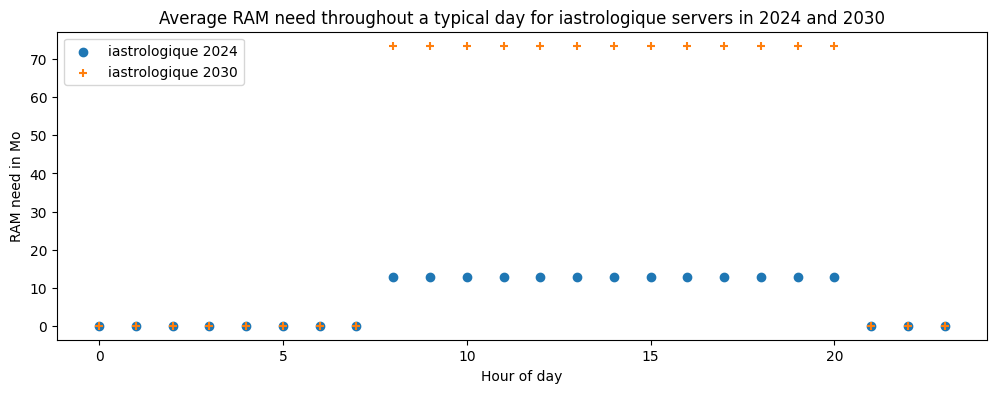

In [14]:
plt.scatter([i for i in range(24)], [elt.value.to(u.Mo).magnitude for elt in iastrologique_server_2024.all_services_ram_needs.value], marker="o", label="iastrologique 2024")
plt.scatter([i for i in range(24)], [elt.value.to(u.Mo).magnitude for elt in iastrologique_server_2030.all_services_ram_needs.value], marker="+", label="iastrologique 2030")
plt.ylabel("RAM need in Mo")
plt.xlabel("Hour of day")
plt.title("Average RAM need throughout a typical day for iastrologique servers in 2024 and 2030")
plt.legend()
plt.show()

As iastrologique server example shows, the needs are very little even in 2030 (less than 100 Mo of RAM need at any time). In fact,

In [15]:
string_to_display = ""
for usage_pattern in iastrologique_server_2030.usage_patterns:
    string_to_display += (f"{usage_pattern.name} in 2030: {usage_pattern.nb_user_journeys_in_parallel_during_usage.magnitude} user journeys in parallel during usage  \n")

md(string_to_display)

IAstrologique usage in France on laptop in 2030: 293.0 user journeys in parallel during usage  


In [16]:
string_to_display = ""
for usage_pattern in iastrologique_server_2024.usage_patterns:
    string_to_display += f"{usage_pattern.name} in 2024: {usage_pattern.nb_user_journeys_in_parallel_during_usage.magnitude} user journeys in parallel during usage  \n"

md(string_to_display)

IAstrologique usage in France on laptop in 2024: 51.0 user journeys in parallel during usage  


... even though the usage has been multiplied by almost 6 from 2024 to 2030 there are still little users in parallel (keeping in mind that the modeling hypothesis is that usage is homogeneous during usage hours so there will be higher spikes in reality). That calls for using smaller machines because even if the modeling underestimates peak load the RAM needs are way under the server capacity of 256 Gb + there is always the possibility of autoscaling if one small server is not enough.

## Storage

Where do the storage fabrication emissions come from ?

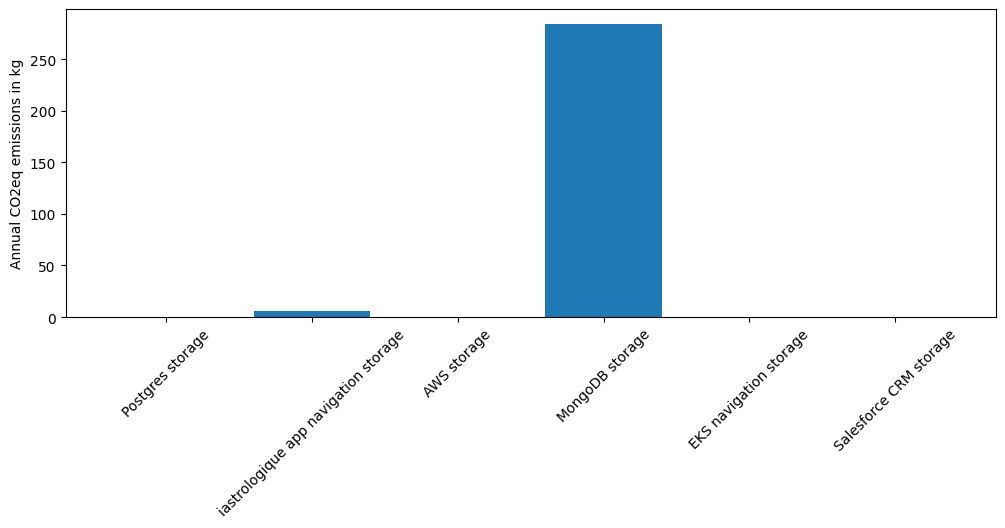

In [17]:
plt.bar([storage.name for storage in iastrologique_systems[2024].storages],
       [storage.instances_fabrication_footprint.to(u.kg / u.year).magnitude for storage in iastrologique_systems[2024].storages])
plt.xticks(rotation=45)
plt.ylabel("Annual CO2eq emissions in kg")
plt.show()

In [18]:
mongodb_storage_2024 = iastrologique_systems[2024].get_storage_by_name("MongoDB storage").long_term_storage_required.value
mongodb_storage_2030 = iastrologique_systems[2030].get_storage_by_name("MongoDB storage").long_term_storage_required.value

md(f"They come from MongoDB by a large margin. In fact in 2024 alone its storage requirements are {round(mongodb_storage_2024, 0)}\
 and they grow to {round(mongodb_storage_2030, 0)} by 2030 !")

They come from MongoDB by a large margin. In fact in 2024 alone its storage requirements are 11.0 teraoctet and they grow to 229.0 teraoctet by 2030 !

What user journeys make up for that storage need ?

In [19]:
mongodb_storage_2024 = iastrologique_systems[2024].get_storage_by_name("MongoDB storage")

string_to_display = ""
for usage_pattern in mongodb_storage_2024.usage_patterns:
    uj = usage_pattern.user_journey
    string_to_display += f"\n{uj.name}:\n  - {round(uj.data_upload.value, 1)} uploaded to services\
 {' and '.join([service.name for service in list(uj.services) if service in mongodb_storage_2024.services])},\n\
  - {round(usage_pattern.user_journey_freq.value, 1)}\n"

md(string_to_display)


One hour of KPI watching per day:
  - 0.0 megaoctet / user_journey uploaded to services Performance visualization,
  - 365.0 user_journey / year

Retrieve and submit pdf documents in IAstrologique in France on laptop:
  - 0.2 megaoctet / user_journey uploaded to services PDF exchange,
  - 220000.0 user_journey / year

IAstrologique usage in France on laptop:
  - 5.1 megaoctet / user_journey uploaded to services Performance tracking and mongodb database,
  - 700000.0 user_journey / year


The vast majority of storage required comes from the main IAstrologique user journey. Let’s have a look at its user journey steps that upload data:

In [20]:
iastrologique_up_2024 = iastrologique_systems[2024].get_usage_pattern_by_name("IAstrologique usage in France on laptop")

string_to_display = ""

for uj_step in iastrologique_up_2024.user_journey.uj_steps:
    if uj_step.data_upload.value > 0 * u.Mo / u.user_journey:
        string_to_display += f"{uj_step.name}: {uj_step.data_upload.value} to {uj_step.service.name}  \n"

md(string_to_display)

1 Salesforce CRM data fetch: 10.0 kilooctet / user_journey to Salesforce CRM  
2 IAstrologique data fetch on postgres: 10.0 kilooctet / user_journey to postgres database  
3 mongodb data fetch: 10.0 kilooctet / user_journey to mongodb database  
4 form filling: 50.0 kilooctet / user_journey to iastrologique  
5 modeling result: 50.0 kilooctet / user_journey to iastrologique  
6 Tracking metrics: 5.0 megaoctet / user_journey to Performance tracking  


It is the Tracking metrics step that uploads the most data. The hypothesis might have to be refined but it is probably the main driver of storage need.

# Conclusion and ecodesign advice

The overall footprint is not very large: at 100€ / ton CO2eq (a good starting point for an internal carbon price), 100 tons CO2eq over the course of 6 years is less than 2000€ / year. However, there are a few points to keep in mind that can easily spare up to a dozen tons CO2 eq by 2030, which is more than the average yearly French citizen emissions of 10 tons CO2eq:

- Put in place a tracking data management policy that deletes or aggregates data after a given lifespan. This could easily divide by 2 the long term storage need and save 3 tons CO2 eq / year by 2030.
- Monitor device computing load if the app requirements exceed that of a typical web app (maybe a few tons of CO2eq per year to save at high usage rates with simple optimizations).
- Use smaller servers, especially during the first few years (probably a few hundreds of tons of CO2eq per year to save without development effort).